# 4. Select the model and run a reasonable result

## 4.1 Importing and Processing Data

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

file_path = '/content/used_device_data.csv'

df_01 = pd.read_csv(file_path, encoding="utf-8")
df_02 = df_01.dropna().copy()

label_encoder_os = LabelEncoder()
label_encoder_4g = LabelEncoder()
label_encoder_5g = LabelEncoder()

df_02['os'] = label_encoder_os.fit_transform(df_02['os'])
df_02['4g'] = label_encoder_4g.fit_transform(df_02['4g'])
df_02['5g'] = label_encoder_5g.fit_transform(df_02['5g'])

print(f'label_encoder_os.classes_: {label_encoder_os.classes_}')
print(f'label_encoder_4g.classes_: {label_encoder_4g.classes_}')
print(f'label_encoder_5g.classes_: {label_encoder_5g.classes_}')
print(df_02.groupby(['device_brand'])['normalized_used_price'].mean().round(2).sort_values(ascending=False))


label_encoder_os.classes_: ['Android' 'Others' 'Windows' 'iOS']
label_encoder_4g.classes_: ['no' 'yes']
label_encoder_5g.classes_: ['no' 'yes']
device_brand
Apple         5.00
Google        4.87
Vivo          4.74
OnePlus       4.70
Realme        4.69
Xiaomi        4.68
Honor         4.67
Oppo          4.67
Huawei        4.65
Meizu         4.54
Sony          4.50
Asus          4.50
Samsung       4.47
HTC           4.41
Motorola      4.38
Lenovo        4.38
ZTE           4.35
Coolpad       4.34
Gionee        4.33
LG            4.30
BlackBerry    4.28
Acer          4.22
Panasonic     4.20
Others        4.17
Microsoft     4.16
Nokia         4.00
Alcatel       3.97
XOLO          3.92
Lava          3.85
Karbonn       3.77
Micromax      3.76
Spice         3.69
Celkon        3.23
Name: normalized_used_price, dtype: float64


##### After filtering out null values and grouping by device_brand, the mean of normalized_used_price ranges from 3.23 to 5.0.
##### So, in the Brand variable, we are going to group them as follows:

Value 0: Below 3.5

Value 1: Above 3.5 and below 4.0

Value 2: Above 4.0 and below 4.5

Value 3: Above 4.5 and below 5.0

Value 4: Above 5.0

In [3]:
def group_brand(value):
    if value < 3.5:
        return 0
    elif 3.5 <= value < 4.0:
        return 1
    elif 4.0 <= value < 4.5:
        return 2
    elif 4.5 <= value < 5:
        return 3
    elif 5.0 <= value:
        return 4
    else:
        return 5

df_02['brand_avg'] = (df_02.groupby(['device_brand'])['normalized_used_price']
                      .transform('mean').round(2))
df_02['brand_group'] = df_02.apply(lambda x: group_brand(x['brand_avg']), axis=1)
df_02 =df_02.drop(columns=['brand_avg'])

print(df_02.columns.tolist())
df_02.loc[:, 'brand_group']


['device_brand', 'os', 'screen_size', '4g', '5g', 'rear_camera_mp', 'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight', 'release_year', 'days_used', 'normalized_used_price', 'normalized_new_price', 'brand_group']


,brand_group
0,3
1,3
2,3
3,3
4,3
...,...
3447,4
3450,3
3451,1
3452,1


## 4.2 Model
#### Feature selection using stepwise regression.
#### Here we use the statsmodels library to implement stepwise regression.
#### Forward Selection: Starting from an empty model, each iteration adds the feature that minimizes the model's AIC (Akaike Information Criterion) value until no further feature significantly reduces the AIC.
#### Backward Elimination: Starting from a model containing all features, each iteration removes the feature that minimizes the model's AIC value (i.e., the feature with the largest p-value), until all remaining features have p-values below a specified threshold.
#### Stepwise: Combines forward and backward methods. After adding a new feature, it examines the features already in the model. If a feature's p-value becomes insignificant, it is removed.

### 4.2.1 Feature Engineering

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

import statsmodels.api as sm
import statsmodels.formula.api as smf


categorical_features = ['device_brand']
numeric_features = [
    'os',
    'screen_size',
    '4g',
    '5g',
    'rear_camera_mp',
    'front_camera_mp',
    'internal_memory',
    'ram',
    'battery',
    'weight',
    'release_year',
    'days_used',
    'normalized_new_price',
    'brand_group'
]


target = 'normalized_used_price'

X = df_02.loc[:, numeric_features]
y = df_02[target]


In [5]:

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.index.equals(y.index))
print(X_train_df.index.equals(y_train.index))
print(X_test_df.index.equals(y_test.index))


True
True
True


### 4.2.2 Stepwise regression for feature selection

In [6]:
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10, verbose=True):
    """
    Stepwise regression function
    X: pandas DataFrame, features
    y: pandas Series, target
    initial_list:
    threshold_in: P-value threshold for model entry (forward selection)
    threshold_out: P-value threshold for model exclusion (backward elimination)
    verbose:
    """
    included = list(initial_list)
    while True:
        changed = False
        # forward selection
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Added feature: {best_feature}, p-value: {best_pval:.4f}')

        # backward elimination
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:] # Eliminate the constant term
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f'Removed feature: {worst_feature}, p-value: {worst_pval:.4f}')

        if not changed:
            break

    return included

print(X_train_df.index)
print(y_train.index)
# Run stepwise regression
print("\n--- Begin stepwise regression feature selection ---")
selected_features = stepwise_selection(X_train_df, y_train,
                                       threshold_in=0.1, threshold_out=0.2, verbose=True)
print("\nFinal selected features: ", selected_features)

# Using the filtered feature subset
X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]


Index([3363, 1405, 1214,  852,  905, 1239,  738, 3276,  442,  174,
       ...
       1328,  547, 2277, 1728, 3211, 1185, 1220, 1384,  947, 3346],
      dtype='int64', length=2602)
Index([3363, 1405, 1214,  852,  905, 1239,  738, 3276,  442,  174,
       ...
       1328,  547, 2277, 1728, 3211, 1185, 1220, 1384,  947, 3346],
      dtype='int64', length=2602)

--- Begin stepwise regression feature selection ---
Added feature: normalized_new_price, p-value: 0.0000
Added feature: release_year, p-value: 0.0000
Added feature: screen_size, p-value: 0.0000
Added feature: rear_camera_mp, p-value: 0.0000
Added feature: front_camera_mp, p-value: 0.0000
Added feature: weight, p-value: 0.0000
Added feature: ram, p-value: 0.0000
Added feature: 4g, p-value: 0.0020
Added feature: days_used, p-value: 0.0952

Final selected features:  ['normalized_new_price', 'release_year', 'screen_size', 'rear_camera_mp', 'front_camera_mp', 'weight', 'ram', '4g', 'days_used']


In [7]:
X_train_model = X_train_df[numeric_features]
X_test_model = X_test_df[numeric_features]

print("\n--- Begin stepwise regression feature selection ---")
selected_features = stepwise_selection(X_train_model, y_train, threshold_in=0.1, threshold_out=0.2, verbose=True)
print("\nFinal selected features:", selected_features)

X_train_selected = X_train_model[selected_features]
X_test_selected = X_test_model[selected_features]


--- Begin stepwise regression feature selection ---
Added feature: normalized_new_price, p-value: 0.0000
Added feature: release_year, p-value: 0.0000
Added feature: screen_size, p-value: 0.0000
Added feature: rear_camera_mp, p-value: 0.0000
Added feature: front_camera_mp, p-value: 0.0000
Added feature: weight, p-value: 0.0000
Added feature: ram, p-value: 0.0000
Added feature: 4g, p-value: 0.0020
Added feature: days_used, p-value: 0.0952

Final selected features: ['normalized_new_price', 'release_year', 'screen_size', 'rear_camera_mp', 'front_camera_mp', 'weight', 'ram', '4g', 'days_used']


### 4.2.3 Train the final multiple linear regression model

In [8]:
# Use statsmodels to train the final model and add a constant term.
final_model = sm.OLS(y_train, sm.add_constant(X_train_selected)).fit()

# Print Model Summary
print("\n--- Final Model Statistical Summary ---")
print(final_model.summary())


--- Final Model Statistical Summary ---
                              OLS Regression Results                             
Dep. Variable:     normalized_used_price   R-squared:                       0.827
Model:                               OLS   Adj. R-squared:                  0.827
Method:                    Least Squares   F-statistic:                     1381.
Date:                   Sun, 05 Oct 2025   Prob (F-statistic):               0.00
Time:                           04:36:18   Log-Likelihood:                 65.261
No. Observations:                   2602   AIC:                            -110.5
Df Residuals:                       2592   BIC:                            -51.88
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

### 4.2.4 Model Evaluation

--- Model Evaluation Metrics (Test Set, Actual Price Scale) ---
Mean Absolute Percentage Error (MAPE): 0.19
RMSE (Log Scale): 0.23
RMSE (Actual Price Scale): 24.77
R-squared (R²) Score: 0.8689

--- Brand Group MAPE (Actual Price Scale) ---
brand_group: 0, MAPE: 0.40, Sample size: 8
brand_group: 1, MAPE: 0.18, Sample size: 84
brand_group: 2, MAPE: 0.19, Sample size: 357
brand_group: 3, MAPE: 0.17, Sample size: 192
brand_group: 4, MAPE: 0.20, Sample size: 10

--- MAPE by OS Group ---
Android Devices: MAPE = 0.18, Sample size = 596
Windows Devices: MAPE = 0.16, Sample size = 13
Other OS Devices: MAPE = 0.32, Sample size = 33
Apple Devices (iOS): MAPE = 0.20, Sample size = 9

--- MAPE by Days Used Group ---
Moderately Used (1-3 years): MAPE = 0.19, Sample size = 567
Lightly Used (≤1 year): MAPE = 0.18, Sample size = 84

--- MAPE by Release Year Group ---
Older Devices (≤2018): MAPE = 0.19, Sample size = 526
Mid-aged Devices (2019-2021): MAPE = 0.18, Sample size = 125

--- MAPE by RAM Group

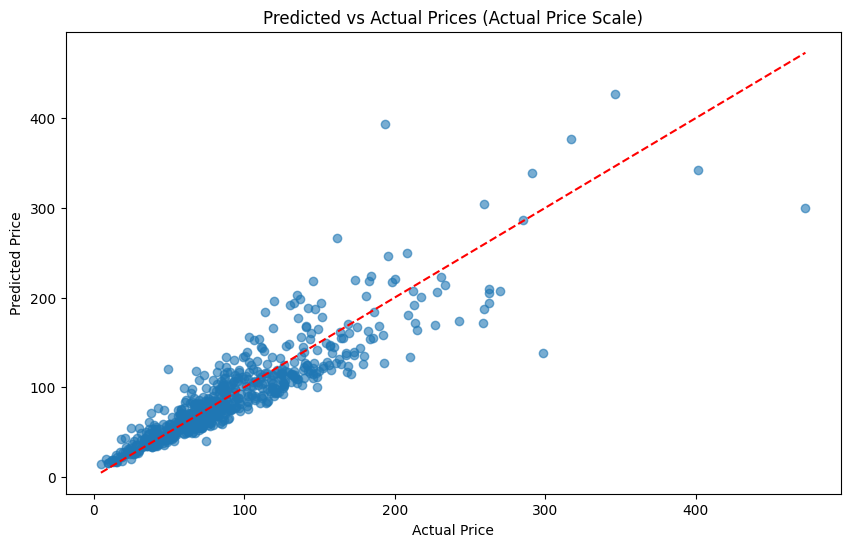

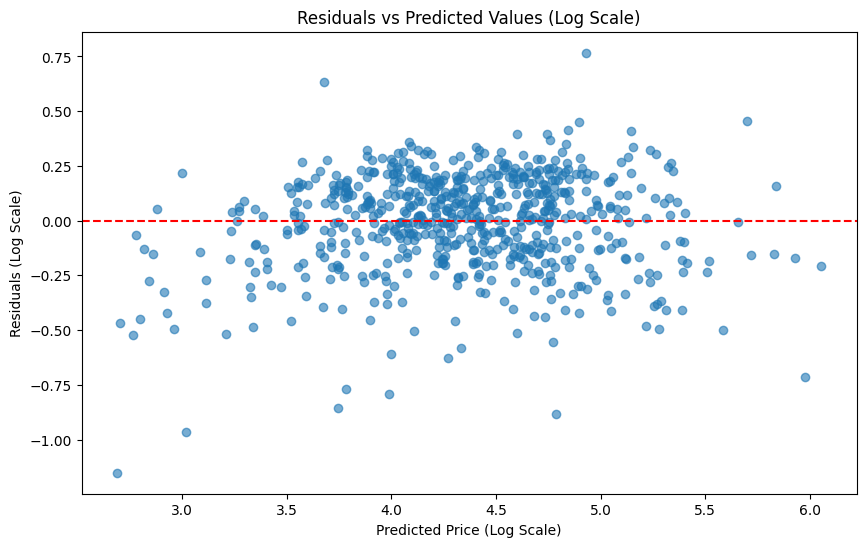

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import statsmodels.api as sm

y_pred = final_model.predict(sm.add_constant(X_test_selected))

actual_price = np.exp(y_test)
pred_price = np.exp(y_pred)

mape = mean_absolute_percentage_error(actual_price, pred_price)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_actual = np.sqrt(mean_squared_error(actual_price, pred_price))
r2 = r2_score(y_test, y_pred)

print("--- Model Evaluation Metrics (Test Set, Actual Price Scale) ---")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}")
print(f"RMSE (Log Scale): {rmse_log:.2f}")
print(f"RMSE (Actual Price Scale): {rmse_actual:.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")

merge_simple = pd.concat(
    [
        X_test_df,
        actual_price.rename("actual_price"),
        pred_price.rename("pred_price")
    ],
    axis=1,
    join='inner'
)

print("\n--- Brand Group MAPE (Actual Price Scale) ---")
for i in range(5):
    df_group = merge_simple[merge_simple['brand_group'] == i]
    if len(df_group) < 5:
        print(f"brand_group: {i}, Insufficient samples ({len(df_group)} records), skipped")
        continue
    mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
    print(f"brand_group: {i}, MAPE: {mape_group:.2f}, Sample size: {len(df_group)}")

def simple_apple_group(os_value):
    if os_value == 3:
        return 'Apple Devices (iOS)'
    elif os_value == 0:
        return 'Android Devices'
    elif os_value == 2:
        return 'Windows Devices'
    elif os_value == 1:
        return 'Other OS Devices'
    else:
        return 'Unknown OS Devices'

merge_simple['os_group'] = merge_simple['os'].apply(simple_apple_group)

print("\n--- MAPE by OS Group ---")
os_groups = merge_simple['os_group'].unique()
for group in os_groups:
    df_group = merge_simple[merge_simple['os_group'] == group]
    if len(df_group) < 5:
        print(f"{group}: Insufficient samples ({len(df_group)} records), skipped")
        continue
    mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
    print(f"{group}: MAPE = {mape_group:.2f}, Sample size = {len(df_group)}")

def simple_days_used_group(days):
    if days <= 365:
        return 'Lightly Used (≤1 year)'
    elif days <= 1095:
        return 'Moderately Used (1-3 years)'
    else:
        return 'Heavily Used (>3 years)'

merge_simple['days_used_group'] = merge_simple['days_used'].apply(simple_days_used_group)

print("\n--- MAPE by Days Used Group ---")
days_groups = merge_simple['days_used_group'].unique()
for group in days_groups:
    df_group = merge_simple[merge_simple['days_used_group'] == group]
    if len(df_group) < 5:
        print(f"{group}: Insufficient samples ({len(df_group)} records), skipped")
        continue
    mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
    print(f"{group}: MAPE = {mape_group:.2f}, Sample size = {len(df_group)}")

def simple_release_year_group(year):
    if year <= 2018:
        return 'Older Devices (≤2018)'
    elif year <= 2021:
        return 'Mid-aged Devices (2019-2021)'
    else:
        return 'Newer Devices (>2021)'

merge_simple['release_year_group'] = merge_simple['release_year'].apply(simple_release_year_group)

print("\n--- MAPE by Release Year Group ---")
year_groups = merge_simple['release_year_group'].unique()
for group in year_groups:
    df_group = merge_simple[merge_simple['release_year_group'] == group]
    if len(df_group) < 5:
        print(f"{group}: Insufficient samples ({len(df_group)} records), skipped")
        continue
    mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
    print(f"{group}: MAPE = {mape_group:.2f}, Sample size = {len(df_group)}")

def simple_ram_group(ram):
    if ram <= 3:
        return 'Low RAM (≤3GB)'
    elif ram <= 4:
        return 'Medium RAM (3-4GB)'
    else:
        return 'High RAM (>4GB)'
merge_simple['ram_group'] = merge_simple['ram'].apply(simple_ram_group)

print("\n--- MAPE by RAM Group ---")
ram_groups = merge_simple['ram_group'].unique()
for group in ram_groups:
    df_group = merge_simple[merge_simple['ram_group'] == group]
    if len(df_group) < 5:
        print(f"{group}: Insufficient samples ({len(df_group)} records), skipped")
        continue
    mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
    print(f"{group}: MAPE = {mape_group:.2f}, Sample size = {len(df_group)}")

plt.figure(figsize=(10, 6))
plt.scatter(merge_simple['actual_price'], merge_simple['pred_price'], alpha=0.6)  # 用 merge_simple 列更稳妥
plt.plot(
    [merge_simple['actual_price'].min(), merge_simple['actual_price'].max()],
    [merge_simple['actual_price'].min(), merge_simple['actual_price'].max()],
    'r--'
)
plt.title('Predicted vs Actual Prices (Actual Price Scale)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values (Log Scale)')
plt.xlabel('Predicted Price (Log Scale)')
plt.ylabel('Residuals (Log Scale)')
plt.show()

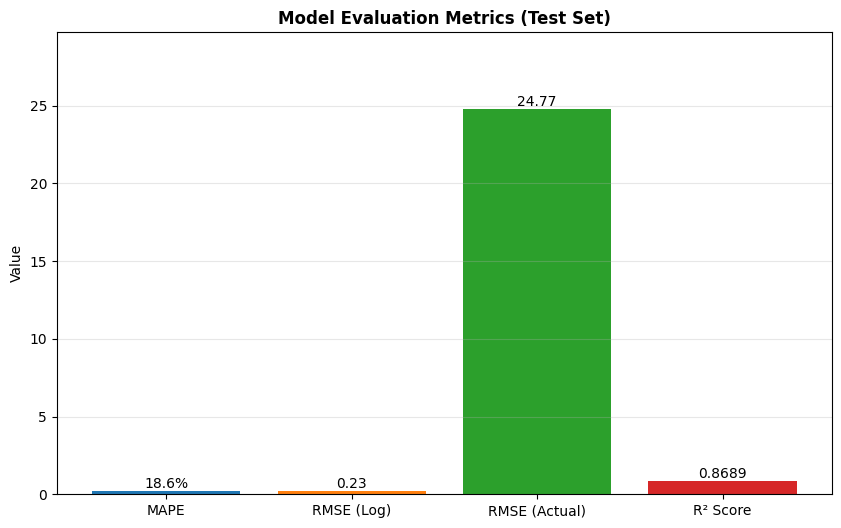

In [10]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['MAPE', 'RMSE (Log)', 'RMSE (Actual)', 'R² Score']
values = [mape, rmse_log, rmse_actual, r2]
formatted_values = [f'{v:.1%}' if i==0 else f'{v:.4f}' if i==3 else f'{v:.2f}' for i, v in enumerate(values)]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
for bar, val in zip(bars, formatted_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             val, ha='center', va='bottom', fontsize=10)

plt.title('Model Evaluation Metrics (Test Set)', fontsize=12, fontweight='bold')
plt.ylabel('Value', fontsize=10)
plt.ylim(0, max(values) * 1.2)
plt.grid(axis='y', alpha=0.3)
plt.show()

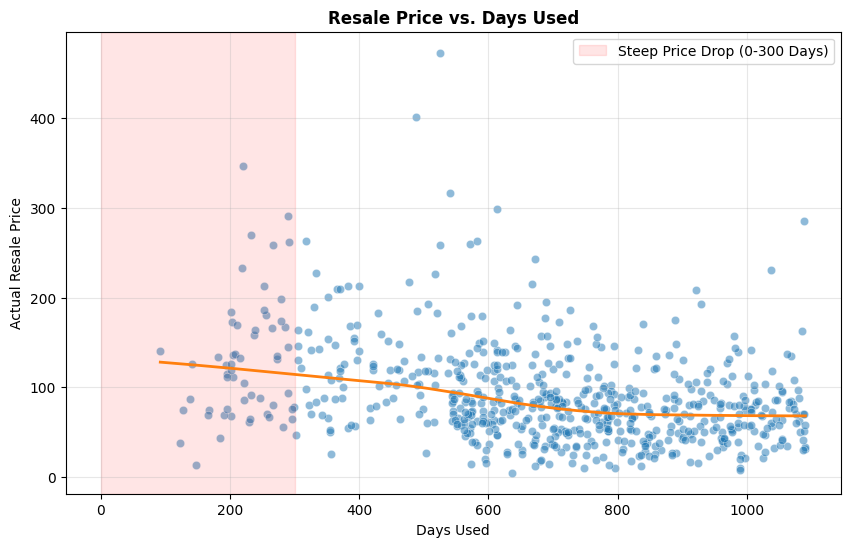

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='days_used', y='actual_price', data=merge_simple, alpha=0.5, color='#1f77b4')
sns.regplot(x='days_used', y='actual_price', data=merge_simple, scatter=False,
            lowess=True, color='#ff7f0e', line_kws={'linewidth':2})

plt.axvspan(0, 300, alpha=0.1, color='red', label='Steep Price Drop (0-300 Days)')
plt.xlabel('Days Used', fontsize=10)
plt.ylabel('Actual Resale Price', fontsize=10)
plt.title('Resale Price vs. Days Used', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

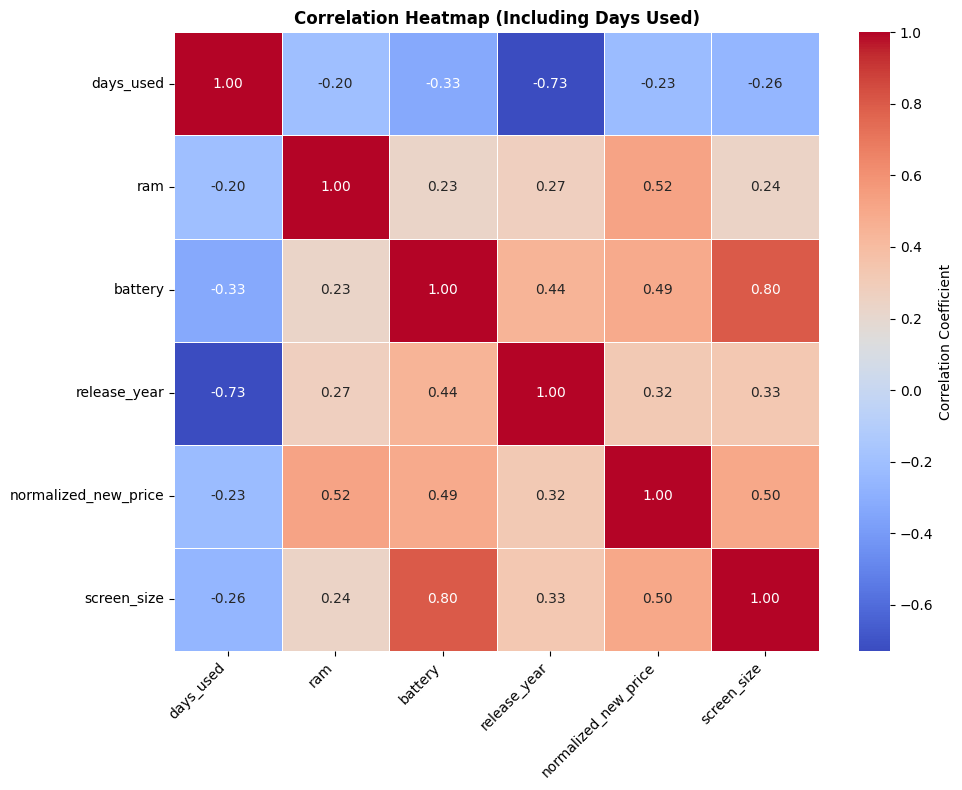

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

corr_features = [ 'days_used', 'ram', 'battery',
                 'release_year', 'normalized_new_price', 'screen_size']
corr_matrix = merge_simple[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap (Including Days Used)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

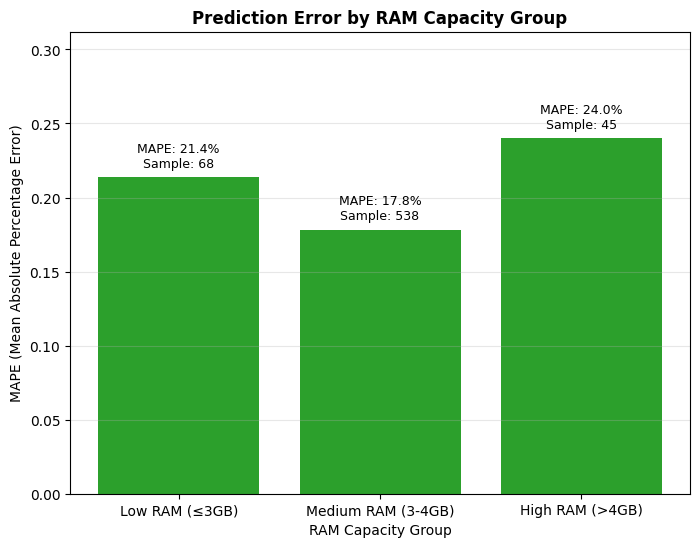

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

ram_mape_data = []
for group in merge_simple['ram_group'].unique():
    df_group = merge_simple[merge_simple['ram_group'] == group]
    if len(df_group) >= 5:  # 过滤样本量不足的组
        mape_group = mean_absolute_percentage_error(df_group['actual_price'], df_group['pred_price'])
        ram_mape_data.append({'RAM Group': group, 'MAPE': mape_group, 'Sample Size': len(df_group)})
ram_mape_df = pd.DataFrame(ram_mape_data)
ram_order = ['Low RAM (≤3GB)', 'Medium RAM (3-4GB)', 'High RAM (>4GB)']
ram_mape_df['RAM Group'] = pd.Categorical(ram_mape_df['RAM Group'], categories=ram_order, ordered=True)
ram_mape_df = ram_mape_df.sort_values('RAM Group')

plt.figure(figsize=(8, 6))
bars = plt.bar(ram_mape_df['RAM Group'], ram_mape_df['MAPE'], color='#2ca02c')
for bar, mape_val, sample_size in zip(bars, ram_mape_df['MAPE'], ram_mape_df['Sample Size']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'MAPE: {mape_val:.1%}\nSample: {sample_size}',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('RAM Capacity Group', fontsize=10)
plt.ylabel('MAPE (Mean Absolute Percentage Error)', fontsize=10)
plt.title('Prediction Error by RAM Capacity Group', fontsize=12, fontweight='bold')
plt.ylim(0, max(ram_mape_df['MAPE']) * 1.3)
plt.grid(axis='y', alpha=0.3)
plt.show()

/tmp/ipython-input-1184891714.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='battery_group', y='actual_price', data=merge_simple, palette='Set2')


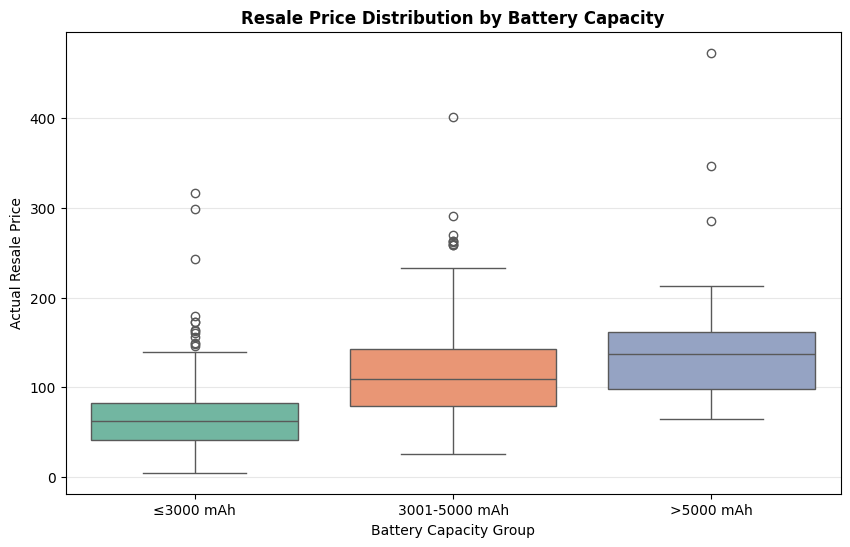

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def battery_group(cap):
    if cap <= 3000:
        return '≤3000 mAh'
    elif cap <= 5000:
        return '3001-5000 mAh'
    else:
        return '>5000 mAh'
merge_simple['battery_group'] = merge_simple['battery'].apply(battery_group)
battery_order = ['≤3000 mAh', '3001-5000 mAh', '>5000 mAh']
merge_simple['battery_group'] = pd.Categorical(merge_simple['battery_group'],
                                               categories=battery_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='battery_group', y='actual_price', data=merge_simple, palette='Set2')
plt.xlabel('Battery Capacity Group', fontsize=10)
plt.ylabel('Actual Resale Price', fontsize=10)
plt.title('Resale Price Distribution by Battery Capacity', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

/tmp/ipython-input-3709957009.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='brand_group_label', y='actual_price', data=merge_simple, palette='Set3')


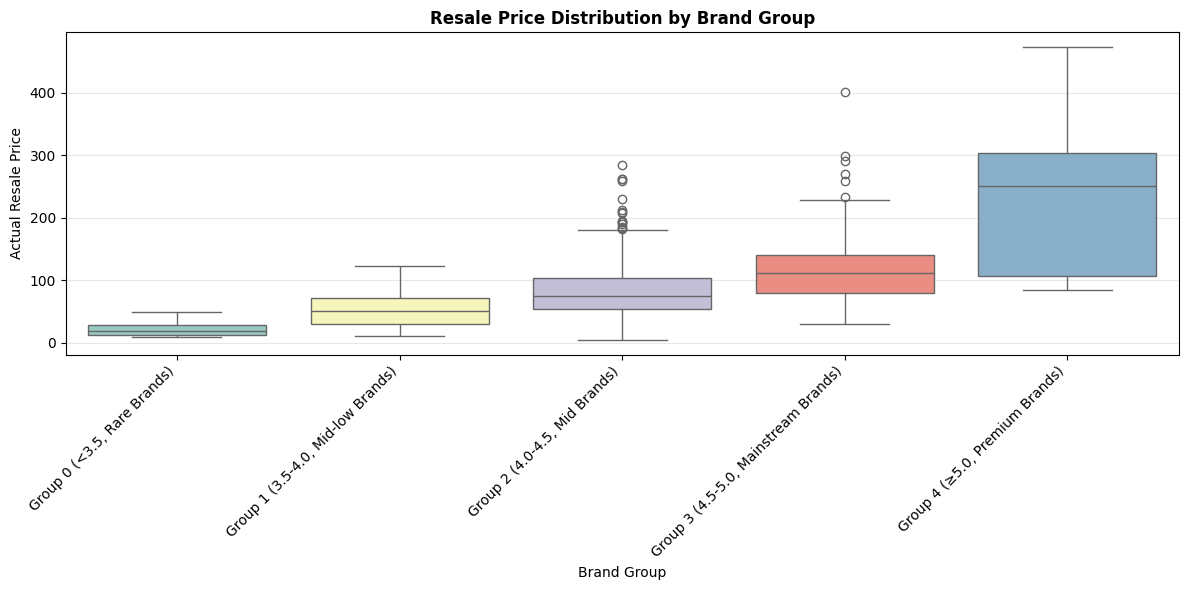

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

brand_labels = {
    0: 'Group 0 (<3.5, Rare Brands)',
    1: 'Group 1 (3.5-4.0, Mid-low Brands)',
    2: 'Group 2 (4.0-4.5, Mid Brands)',
    3: 'Group 3 (4.5-5.0, Mainstream Brands)',
    4: 'Group 4 (≥5.0, Premium Brands)'
}
merge_simple['brand_group_label'] = merge_simple['brand_group'].map(brand_labels)
brand_order = [brand_labels[i] for i in range(5)]
merge_simple['brand_group_label'] = pd.Categorical(merge_simple['brand_group_label'],
                                                   categories=brand_order, ordered=True)

plt.figure(figsize=(12, 6))
sns.boxplot(x='brand_group_label', y='actual_price', data=merge_simple, palette='Set3')
plt.xlabel('Brand Group', fontsize=10)
plt.ylabel('Actual Resale Price', fontsize=10)
plt.title('Resale Price Distribution by Brand Group', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # 旋转标签避免重叠
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

/tmp/ipython-input-4020921488.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='os_group', y='actual_price', data=merge_simple_os, palette='Set1')


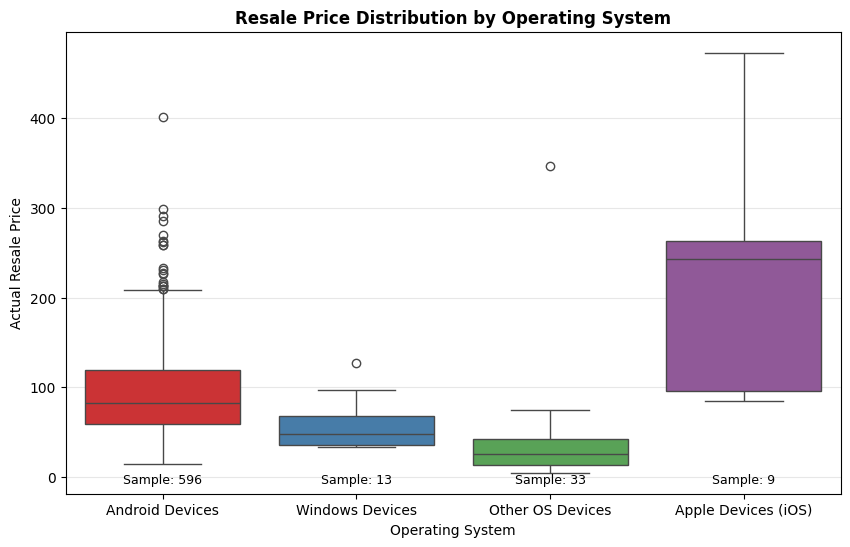

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

os_groups_to_show = [g for g in merge_simple['os_group'].unique() if len(merge_simple[merge_simple['os_group']==g])>=5]
merge_simple_os = merge_simple[merge_simple['os_group'].isin(os_groups_to_show)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='os_group', y='actual_price', data=merge_simple_os, palette='Set1')
for i, os_group in enumerate(os_groups_to_show):
    sample_size = len(merge_simple[merge_simple['os_group']==os_group])
    plt.text(i, merge_simple_os['actual_price'].min() * 0.9,
             f'Sample: {sample_size}', ha='center', va='top', fontsize=9)

plt.xlabel('Operating System', fontsize=10)
plt.ylabel('Actual Resale Price', fontsize=10)
plt.title('Resale Price Distribution by Operating System', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

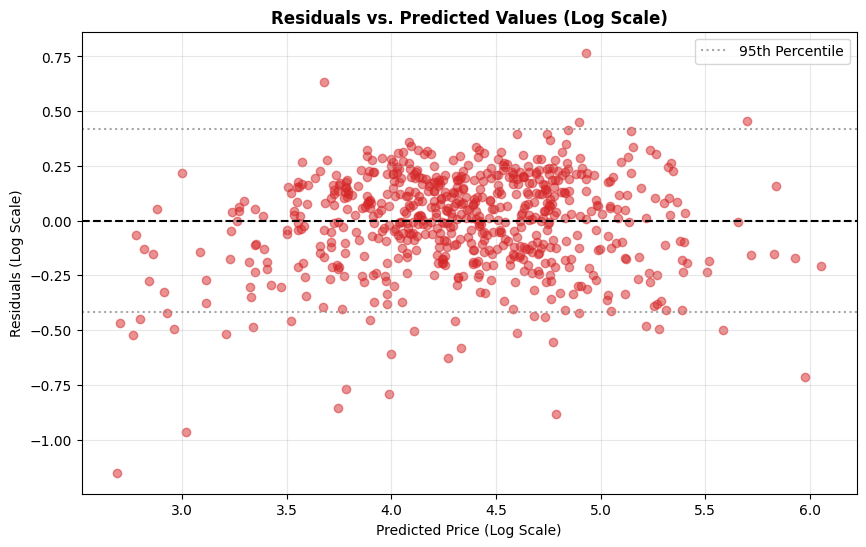

In [17]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#d62728')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
abs_residual_threshold = np.percentile(np.abs(residuals), 95)
plt.axhline(y=abs_residual_threshold, color='gray', linestyle=':', alpha=0.7, label='95th Percentile')
plt.axhline(y=-abs_residual_threshold, color='gray', linestyle=':', alpha=0.7)

plt.xlabel('Predicted Price (Log Scale)', fontsize=10)
plt.ylabel('Residuals (Log Scale)', fontsize=10)
plt.title('Residuals vs. Predicted Values (Log Scale)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### 4.2.5 Interpretation and Summary of Results

Feature selection results: Stepwise regression automatically filters features based on the AIC criterion. In our simulated data, it is likely to select most of the features we used to construct prices and may exclude some features with minor influence or those exhibiting multicollinearity.

Model Summary Interpretation: R-squared: Represents the percentage of price variation explained by the model. For example, an R² value of 0.86 indicates the model accounts for 86% of fluctuations in used mobile phone prices. P>|t| (p-value): Used to test whether the coefficient is significantly different from zero. Typically, if the p-value is less than 0.05, we consider the feature to make a significant contribution to the model. Stepwise regression has already handled this for us. RMSE: Represents the average error between the model's predicted price and the actual price.